In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
sns.set()

import warnings
warnings.filterwarnings("ignore")

Leemos los datasets y los guardamos en variables

In [2]:
df_steam_games = pd.read_parquet('../data/ETL2_steam_games.parquet')


In [3]:
df_users_reviews = pd.read_parquet('../data/users_reviews_final.parquet')

In [4]:
df_user_items = pd.read_parquet('../data/ETL1_users_items.parquet')

## Dataset "user_reviews"

In [5]:
df_users_reviews.head()

,user_id,reviews_posted,reviews_item_id,reviews_recommend,sentiment_analysis
0,76561197970982479,2011-11-05,1250,True,2
1,js41637,2014-06-24,251610,True,2
2,evcentric,formato invalido,248820,True,2
3,doctr,2013-10-14,250320,True,2
4,maplemage,2014-04-15,211420,True,1


In [6]:
df_users_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59006 entries, 0 to 59005
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             59006 non-null  object
 1   reviews_posted      59006 non-null  object
 2   reviews_item_id     59006 non-null  int64 
 3   reviews_recommend   59006 non-null  bool  
 4   sentiment_analysis  59006 non-null  int64 
dtypes: bool(1), int64(2), object(2)
memory usage: 1.9+ MB


Campos 'reviews_recommend' y 'sentiment_analysis'

In [7]:
df_users_reviews['reviews_recommend'].describe()

count     59006
unique        2
top        True
freq      52206
Name: reviews_recommend, dtype: object

In [8]:
reviews_recommend_acum = df_users_reviews['reviews_recommend'].value_counts()
reviews_recommend_acum

True     52206
False     6800
Name: reviews_recommend, dtype: int64

In [9]:
df_users_reviews['reviews_recommend'].unique()

array([ True, False])

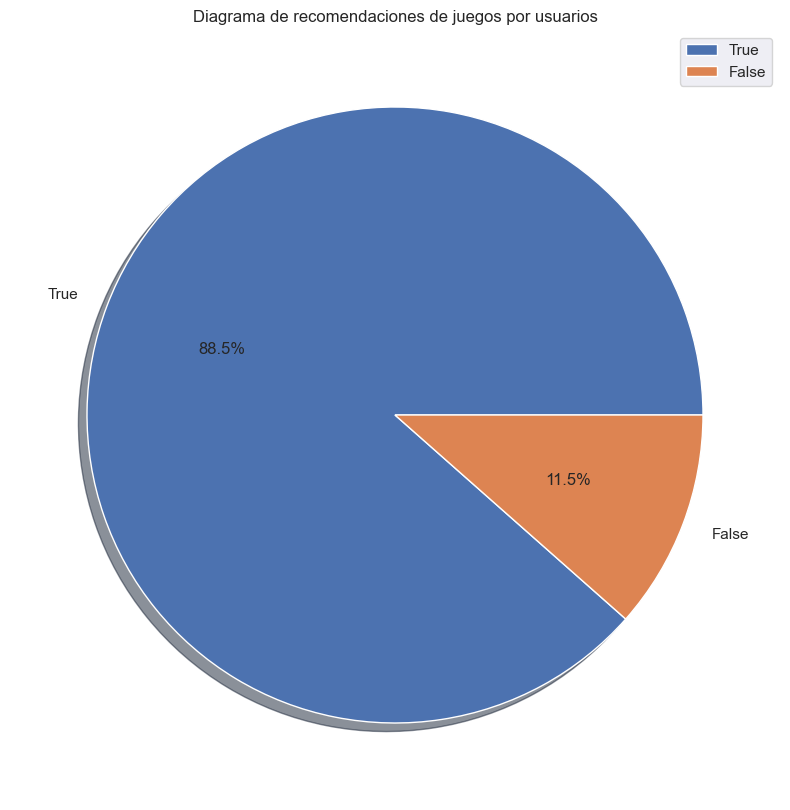

In [10]:
fig,ax= plt.subplots(figsize= (20,10))
ax.pie(reviews_recommend_acum, labels= reviews_recommend_acum.index, shadow= True, autopct='%1.1f%%')

plt.title('Diagrama de recomendaciones de juegos por usuarios')
plt.legend()
plt.show()

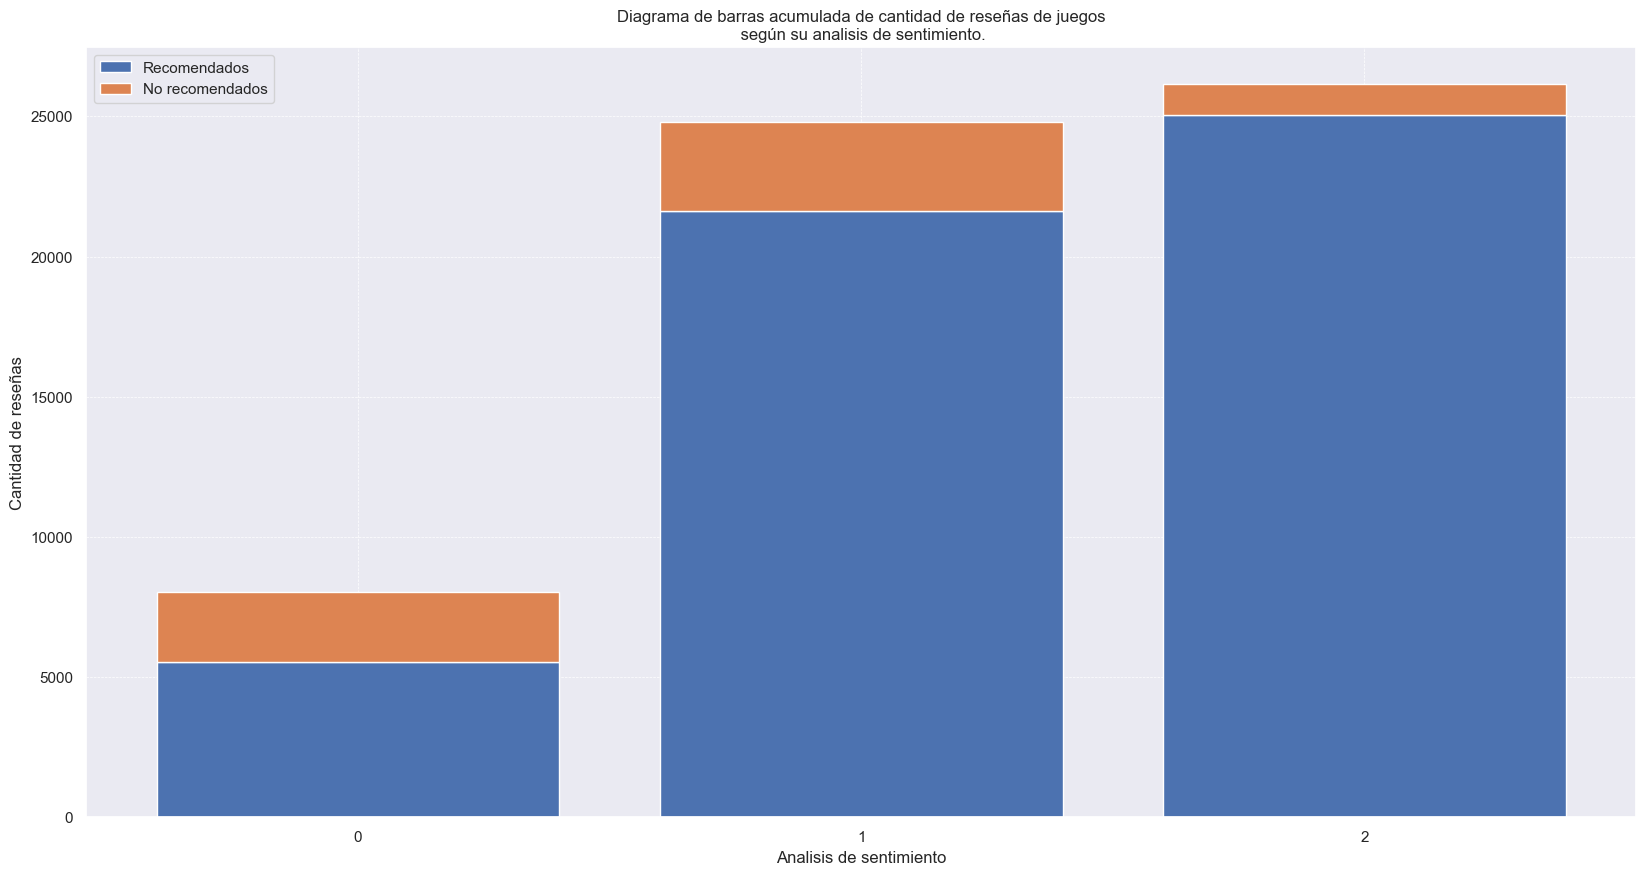

In [11]:
data = df_users_reviews
clases = ['0', '1', '2']


df_recomendado = data[data['reviews_recommend'] == True].groupby(['reviews_recommend','sentiment_analysis']).size()
df_no_recomendado = data[data['reviews_recommend'] == False].groupby(['reviews_recommend','sentiment_analysis']).size()

lista = [df_recomendado, df_no_recomendado]
estados = ['Recomendados', 'No recomendados']

fig,ax= plt.subplots(figsize= (20,10))
x = np.arange(1,len(clases)+1)
bottom = np.zeros(len(clases))

for estado, df in zip(estados,lista):

    ax.bar(x, df.values, label= estado, bottom = bottom)
    bottom += df.values

plt.xlabel('Analisis de sentimiento')
plt.ylabel('Cantidad de reseñas')
ax.set_xticks(x, clases)
plt.legend()
plt.title('Diagrama de barras acumulada de cantidad de reseñas de juegos\n según su analisis de sentimiento.')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### Rank 5 juegos con mayor puntaje de sentimiento positivo (entre los juegos NO RECOMENDADOS)

Analizamos registros con incongruencias entre las recomedaciones de juegos en los comentarios y la valoracion de los juegos en los comentarios

In [12]:
# registros donde 'reviews_recommend' es falso, y el analisis de sentimiento ('sentiment_analysis') da 1 o 2 (es decir, da valoracion neutra o positiva)
# esto nos plantea una contradiccion entre la recomendacion y el resultado del analisis de sentimiento, principalmente en los que tienen una valoracion de 
# sentimiento de 2

muestra = df_users_reviews[(df_users_reviews['reviews_recommend'] == False) & (df_users_reviews['sentiment_analysis'] >= 1)]
muestra

,user_id,reviews_posted,reviews_item_id,reviews_recommend,sentiment_analysis
52,sandwiches1,2015-11-23,417860,False,1
70,76561198010674657,formato invalido,377160,False,1
86,ii_voltage_ii,2014-06-29,253710,False,1
91,Xx-Woods,formato invalido,346330,False,1
111,Koolcaz12,formato invalido,298050,False,2
...,...,...,...,...,...
58945,1011001,2014-10-28,222880,False,2
58947,profilezinga,2015-04-12,213330,False,1
58972,76561198082767148,formato invalido,730,False,1
58975,jefftequilla,2014-12-17,222900,False,1


In [13]:
# tomamos de nuestra muestra, la columna de analisis de sentimiento y la agrupamos por item (item_id) y tomamos los primeros 5 que
# tienen mayor puntuacion de sentimiento.

puntuacion_rank_5 = pd.DataFrame(muestra.groupby('reviews_item_id')['sentiment_analysis'].sum().sort_values(ascending= False).nlargest(5))
puntuacion_rank_5

,sentiment_analysis
reviews_item_id,
730,242
218620,228
221100,116
440,103
570,97


In [14]:
## veamos cuales son estos juegos de nuestro ranking
juegos_rank_5 =  df_steam_games[df_steam_games['id'].isin(list(puntuacion_rank_5.index))].drop_duplicates('id') 
juegos_rank_5

,publisher,genres,app_name,release_date,price,early_access,id,developer
1685,Valve,Action,Counter-Strike: Global Offensive,2012,14.99,0.0,730,Valve
67163,Bohemia Interactive,Action,DayZ,2013,34.99,1.0,221100,Bohemia Interactive
70998,Valve,Action,Team Fortress 2,2007,0.00,0.0,440,Valve


In [15]:
# reiniciamos el indice del dataframe
temp = puntuacion_rank_5.reset_index()

# cambiamos el tipo de dato del campo reviews_item_id, para evitar errores de lectura en el grafico
temp['reviews_item_id'] = temp['reviews_item_id'].astype('str')

# creamos una lista de etiquetas que nos informe el id del juego y su nombre correspondiente para pasarla al eje x de nuestro futuro grafico
etiquetas= [f'730 = {juegos_rank_5["app_name"].iloc[0]}',
            '218620 = Sin registro',
            f'221100 = {juegos_rank_5["app_name"].iloc[1]}',
            f'440 = {juegos_rank_5["app_name"].iloc[2]}',
            '570 = Sin registro',]

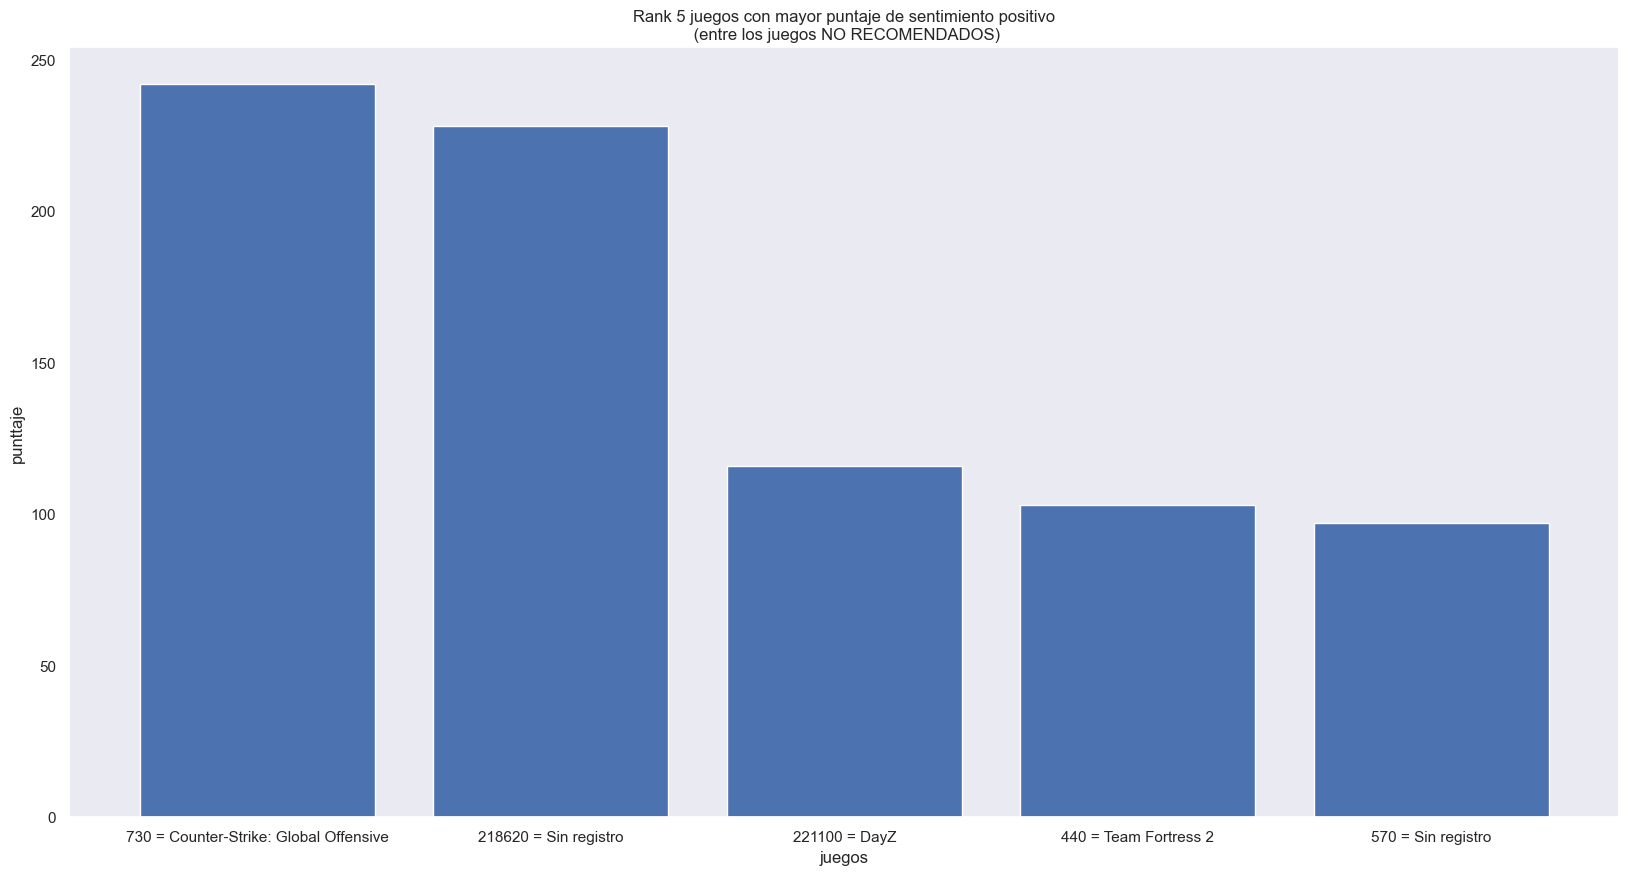

In [16]:
fig, ax = plt.subplots(figsize= (20,10))
ax.bar(temp['reviews_item_id'], temp['sentiment_analysis'])

plt.title('Rank 5 juegos con mayor puntaje de sentimiento positivo\n (entre los juegos NO RECOMENDADOS)')
plt.xlabel('juegos')
plt.ylabel('punttaje')
# plt.legend('Juegos')
plt.xticks(list(range(0,5)), etiquetas)
plt.grid()
plt.show()

### Rank 10 juegos recomendados con mayor puntaje de sentimiento positivo

In [17]:
# averiguemos cuantas reviews hay por cada juego con opiniones

df_users_reviews['reviews_item_id'].value_counts().nlargest(10)

730       3746
440       3719
4000      1724
570       1556
218620    1131
304930    1043
252490     815
550        746
221100     735
105600     733
Name: reviews_item_id, dtype: int64

Por lo que vemos en este conteo de los juegos con mas opiniones, se encuentran los 5 juegos del ranking de juegos con mas puntaje de sentimiento positivo y recomendacion negativa.

In [18]:
# veamos los registros de empresas con sentimiento positivo y recomendacion positiva
muestra = df_users_reviews[(df_users_reviews['reviews_recommend'] == True) & (df_users_reviews['sentiment_analysis'] >= 1)]
muestra

,user_id,reviews_posted,reviews_item_id,reviews_recommend,sentiment_analysis
0,76561197970982479,2011-11-05,1250,True,2
1,js41637,2014-06-24,251610,True,2
2,evcentric,formato invalido,248820,True,2
3,doctr,2013-10-14,250320,True,2
4,maplemage,2014-04-15,211420,True,1
...,...,...,...,...,...
58999,76561198133319761,2014-06-27,238460,True,2
59001,SKELETRONPRIMEISOP,2014-08-15,440,True,1
59002,76561198141079508,2014-08-02,304930,True,1
59003,ShadowYT100,2015-07-31,265630,True,2


In [19]:
# hacemos la sumatoria total del analisis de sentimiento de las empresas recomendadas
puntuacion_rank_10 = pd.DataFrame(muestra.groupby('reviews_item_id')['sentiment_analysis'].sum().sort_values(ascending= False).nlargest(10)).reset_index()
puntuacion_rank_10
# obtenemos el ranking de las 10 emepresas con mayor puntuacion positiva

,reviews_item_id,sentiment_analysis
0,440,5174
1,730,4616
2,4000,2280
3,570,1937
4,304930,1288
5,218620,1228
6,105600,1035
7,550,987
8,252490,944
9,72850,938


In [20]:
## veamos cuales son estos juegos de nuestro ranking
# identificamos los nombres de los items (o sea, los juegos) correspondientes al ranking
juegos_rank_10 =  df_steam_games[df_steam_games['id'].isin(list(puntuacion_rank_10['reviews_item_id']))].drop_duplicates('id')[['id', 'app_name']]
puntuacion_rank_10 = puntuacion_rank_10.rename(columns= {'reviews_item_id': 'id'})

In [21]:
puntuacion_rank_final = puntuacion_rank_10.merge(juegos_rank_10, how= 'left', on= 'id')


In [22]:
# reemplazamos los valores NaN por la cadena 'sin dato'
puntuacion_rank_final.fillna('Sin dato', inplace= True)
puntuacion_rank_final

,id,sentiment_analysis,app_name
0,440,5174,Team Fortress 2
1,730,4616,Counter-Strike: Global Offensive
2,4000,2280,Garry's Mod
3,570,1937,Sin dato
4,304930,1288,Unturned
5,218620,1228,Sin dato
6,105600,1035,Terraria
7,550,987,Left 4 Dead 2
8,252490,944,Rust
9,72850,938,Sin dato


In [23]:
puntuacion_rank_final['id'] = puntuacion_rank_final['id'].astype('str')

In [24]:
etiquetas = list()

for idx in range(0,len(puntuacion_rank_final)):
    etiquetas.append(f'{puntuacion_rank_final["id"].iloc[idx]}: {puntuacion_rank_final["app_name"].iloc[idx]}')

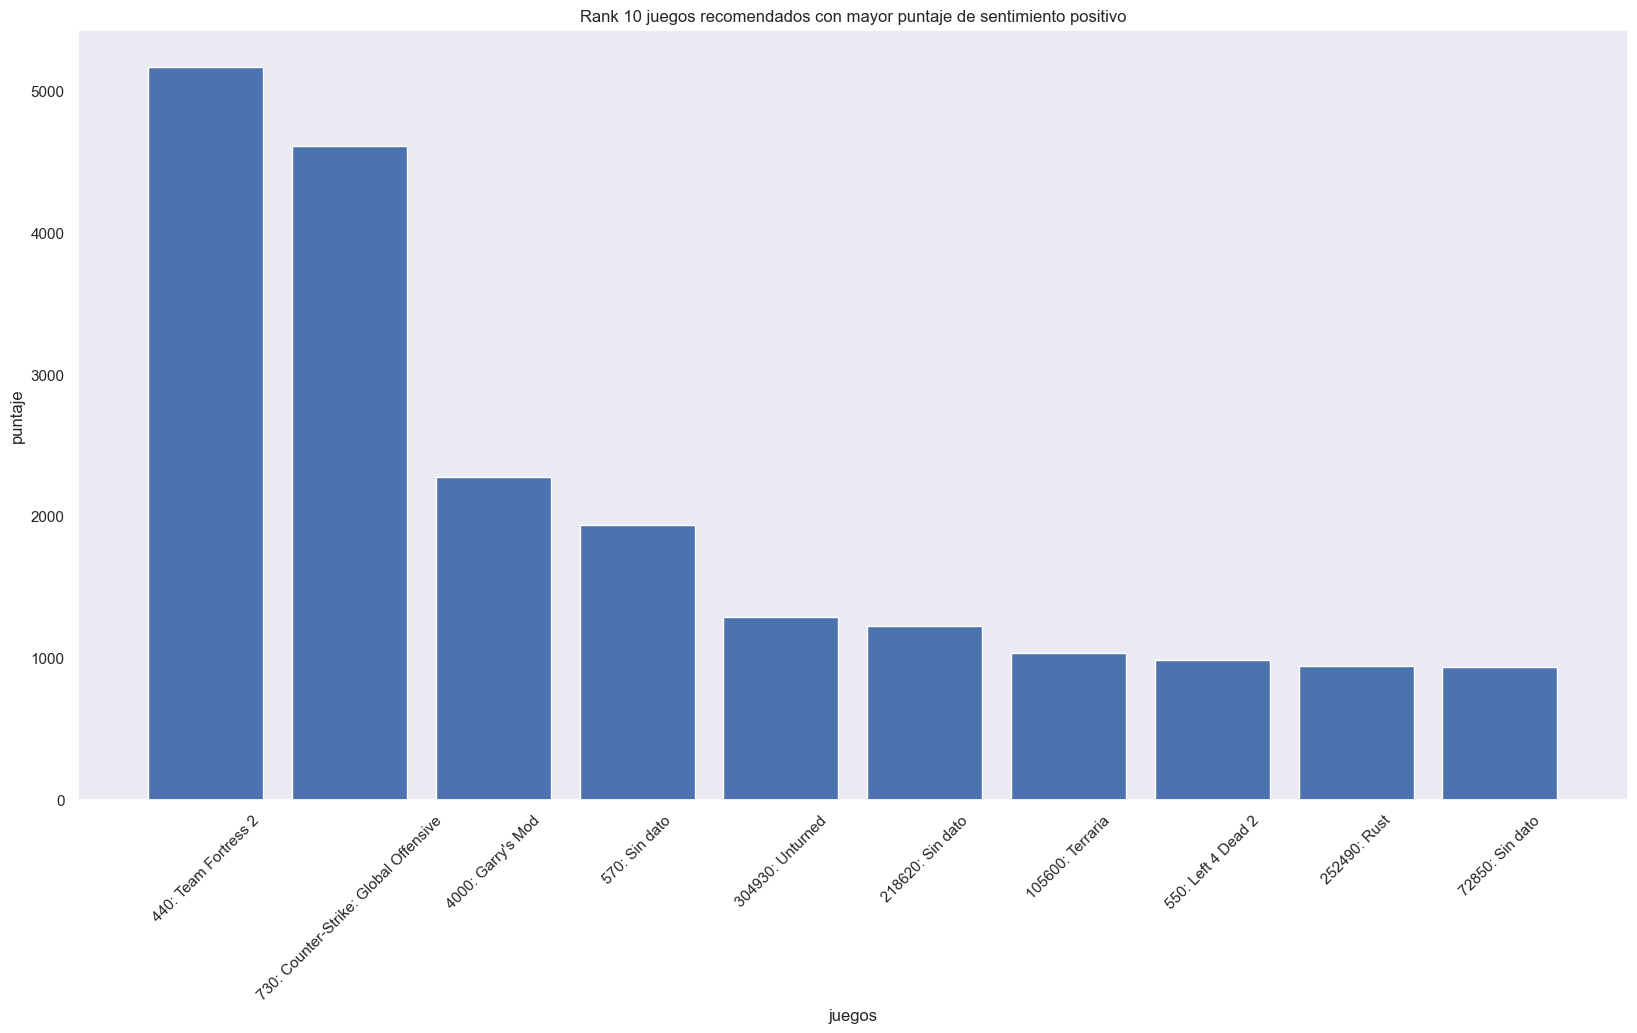

In [25]:
#graficamos

fig, ax = plt.subplots(figsize= (20,10))
ax.bar(puntuacion_rank_final['id'], puntuacion_rank_final['sentiment_analysis'])

plt.title('Rank 10 juegos recomendados con mayor puntaje de sentimiento positivo')
plt.xlabel('juegos')
plt.ylabel('puntaje')
plt.xticks(list(range(0,10)), etiquetas, rotation= 45)
plt.grid()
plt.show()

### -------------------------------------------------------------------------------------------------------------------------

## Dataset "steam_games"

In [26]:
df_steam_games.head()

,publisher,genres,app_name,release_date,price,early_access,id,developer
0,Kotoshiro,Action,Lost Summoner Kitty,2018,4.99,0.0,761140,Kotoshiro
1,Kotoshiro,Casual,Lost Summoner Kitty,2018,4.99,0.0,761140,Kotoshiro
2,Kotoshiro,Indie,Lost Summoner Kitty,2018,4.99,0.0,761140,Kotoshiro
3,Kotoshiro,Simulation,Lost Summoner Kitty,2018,4.99,0.0,761140,Kotoshiro
4,Kotoshiro,Strategy,Lost Summoner Kitty,2018,4.99,0.0,761140,Kotoshiro


In [27]:
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71552 entries, 0 to 71551
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     71552 non-null  object 
 1   genres        71552 non-null  object 
 2   app_name      71552 non-null  object 
 3   release_date  71552 non-null  object 
 4   price         71552 non-null  float64
 5   early_access  71552 non-null  float64
 6   id            71552 non-null  int64  
 7   developer     71552 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 4.4+ MB


In [28]:
df_steam_games.isna().sum()

publisher       0
genres          0
app_name        0
release_date    0
price           0
early_access    0
id              0
developer       0
dtype: int64

In [29]:
## comparemos los valores en la columna developer con los valores en la columna publisher

In [30]:
muestra = df_steam_games[['developer', 'publisher']]  # separamos la muestra

temp= muestra[muestra['developer'] != muestra['publisher']] # establecemos el filtro 
temp.drop_duplicates()  # obtenemos los valores unicos de nuestra muestra

,developer,publisher
5,Secret Level SRL,"Making Fun, Inc."
20,Poppermost Productions,no hay dato
103,The Commander,no hay dato
106,"lalalaZero,Urbanoff",Cisamid Inc.
112,Outerlight Ltd.,Blazing Griffin Ltd.
...,...,...
71485,CyberLink,Koch Media
71497,Gearbox Software,Valve
71507,I.O.S. Team,no hay dato
71510,ToonTRAXX Studios,Topware Interactive


In [39]:
df_steam_games

,publisher,genres,app_name,release_date,price,early_access,id,developer
0,Kotoshiro,Action,Lost Summoner Kitty,2018,4.99,0.0,761140,Kotoshiro
1,Kotoshiro,Casual,Lost Summoner Kitty,2018,4.99,0.0,761140,Kotoshiro
2,Kotoshiro,Indie,Lost Summoner Kitty,2018,4.99,0.0,761140,Kotoshiro
3,Kotoshiro,Simulation,Lost Summoner Kitty,2018,4.99,0.0,761140,Kotoshiro
4,Kotoshiro,Strategy,Lost Summoner Kitty,2018,4.99,0.0,761140,Kotoshiro
...,...,...,...,...,...,...,...,...
71547,Laush Studio,Indie,Russian Roads,2018,1.99,0.0,610660,Laush Dmitriy Sergeevich
71548,Laush Studio,Racing,Russian Roads,2018,1.99,0.0,610660,Laush Dmitriy Sergeevich
71549,Laush Studio,Simulation,Russian Roads,2018,1.99,0.0,610660,Laush Dmitriy Sergeevich
71550,SIXNAILS,Casual,EXIT 2 - Directions,2017,4.99,0.0,658870,"xropi,stev3ns"


Columna 'genres'

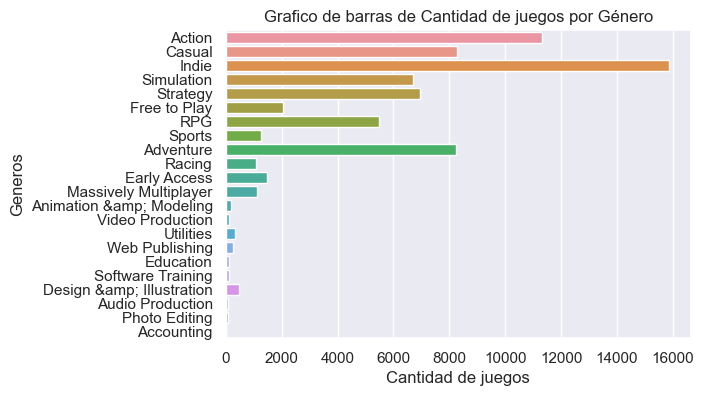

In [40]:
# graficamos un conteo de frecuencias por generos
plt.figure(figsize=(6, 4))
sns.countplot(data=df_steam_games, y='genres', orient='h')
plt.title('Grafico de barras de Cantidad de juegos por Género')
plt.xlabel('Cantidad de juegos')
plt.ylabel('Generos')
plt.show()

## Una observacion es que los generos por cada juego individual estan individualizados, por lo que un mismo registro se suma para cada uno de los generos que representa
## ejemplo: el juego x esntra en los generos: Action, Casual y Simulation, por lo que suma una observacion en cada uno de estos generos

Los juegos estan categorizados mayormente en las categorías Indi, Action, Casual y Adventure. Cabe recordar que un juego puede tener mas de un género asociado.

Columna 'relese_date'

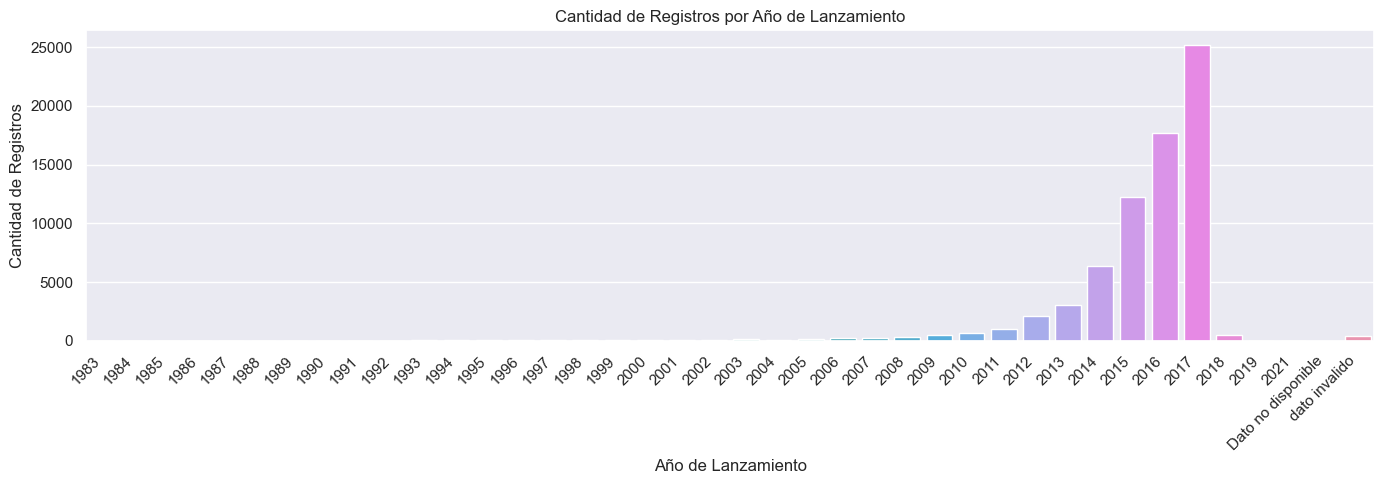

In [41]:
# Cuenta la frecuencia de cada año
conteo_anios = df_steam_games['release_date'].value_counts()

# Ordena los valores para que 'Datos no disponibles' queden al principio o al final
conteo_anios = conteo_anios.reindex(['Dato no disponible'] + list(conteo_anios.index))
# Ordena los valores por año
conteo_anios = conteo_anios.sort_index()

# Crear la gráfica de barras
plt.figure(figsize=(14, 5))
sns.barplot(x=conteo_anios.index, y=conteo_anios.values)
plt.xlabel('Año de Lanzamiento') ; plt.ylabel('Cantidad de Registros') ; plt.title('Cantidad de Registros por Año de Lanzamiento')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [47]:
# Filtra los registros con valores numéricos en la columna 'release_anio'
registros_numericos = df_steam_games[df_steam_games['release_date'].str.isnumeric()]
# Convierte la columna 'release_anio' a valores enteros
registros_numericos['release_date'] = registros_numericos['release_date'].astype(int)
# Filtra los registros con años de lanzamiento antes de 2002
registros_antes_2002 = registros_numericos[registros_numericos['release_date'] < 2002]

print(f"Cantidad de registros antes de 2002: {len(registros_antes_2002)}")
print(f"Cantidad de registros 'Dato no disponible': {df_steam_games['release_date'][df_steam_games['release_date'] == 'dato invalido'].count()}")

Cantidad de registros antes de 2002: 679
Cantidad de registros 'Dato no disponible': 391


Se pueden ver 679 juegos lanzados en años anteriores al 2002 lo que puede ser un error porque la plataforma se lanzó en el 2003. Por otra parte, se observan 391 juegos sin la fecha disponible debido a que no estaba especificada o estaba en un formato incorrecto. Luego se ve el crecimiento constante y lento hasta 2012 y luego crece mas rápidamente hasta 2017. A partir de allí, la plataforma limitó la forma de obtener las estadísticas, por eso se ven muchos menos registros.

Columna 'price'

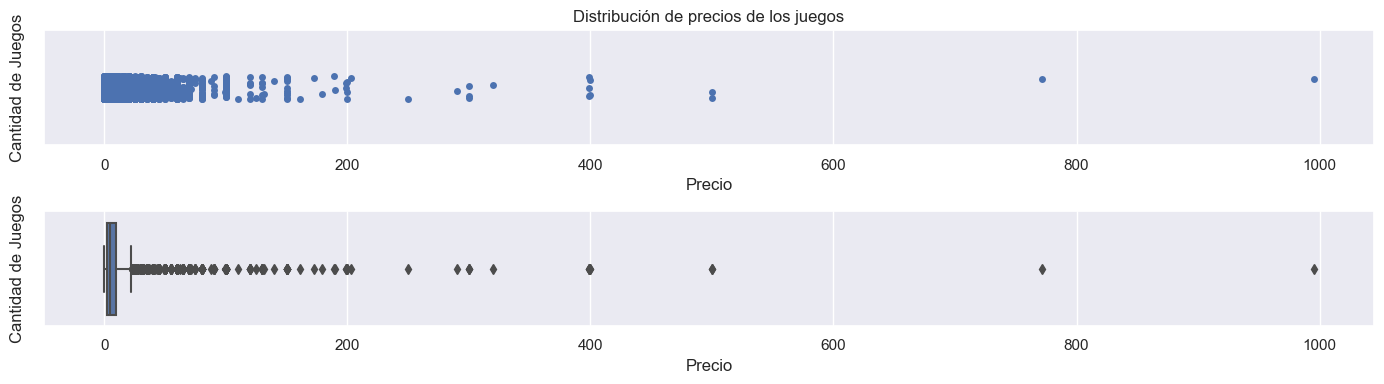

In [48]:
# Obtiene los precios para cada juego y hace un dataframe
precio_unicos = df_steam_games.groupby('id')['price'].unique().reset_index().explode('price')
df_precio_unicos = precio_unicos['price']

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=df_precio_unicos, x=df_precio_unicos, ax=ax1)
ax1.set_xlabel('Precio') ; ax1.set_ylabel('Cantidad de Juegos') ; ax1.set_title('Distribución de precios de los juegos')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=df_precio_unicos, x=df_precio_unicos, ax=ax2)
ax2.set_xlabel('Precio') ; ax2.set_ylabel('Cantidad de Juegos')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

In [50]:
# Obtenemos algunas estadisticas
estadisticas = df_precio_unicos.astype(float).describe()
estadisticas

count    28850.000000
mean         8.622707
std         15.720321
min          0.000000
25%          1.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64

In [54]:
# Cuartiles
q1 = estadisticas[4]
q3 = estadisticas[6]

# Valor del bigote
bigote_max = round(q3 + 1.5*(q3 - q1), 2)

# cantidad de atipicos (outliers)
outliers = (df_precio_unicos > bigote_max).sum()

print(outliers)

1746


Casi el 50% de los juegos tienen precios entre 0 y los 4.99 dolares y el 75% de los juegos tienen precios inferior a los 9.99 dolares. Se Observan 1746 valores que se pueden considerar atípicos, con precios superior a los 21.99 dolares, pero sin dudas hay algunos juegos de mas de 200 dolares aprox. que pueden considerarse errores en los precios.

## Dataset "user_items"

In [31]:
df_user_items.head()

,item_id,item_name,playtime_forever,steam_id,items_count,user_id,user_url
0,10,Counter-Strike,6,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,20,Team Fortress Classic,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,30,Day of Defeat,7,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,40,Deathmatch Classic,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
4,50,Half-Life: Opposing Force,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...


In [32]:
df_user_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094105 entries, 0 to 5094104
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   item_id           int64 
 1   item_name         object
 2   playtime_forever  int64 
 3   steam_id          int64 
 4   items_count       int64 
 5   user_id           object
 6   user_url          object
dtypes: int64(4), object(3)
memory usage: 272.1+ MB


In [33]:
# eliminamos la columna 'user_url' ya que no contiene informacion relevante para nuestro analisis
df_user_items.drop(columns= 'user_url', inplace= True)

In [34]:
df_user_items.isna().sum()

item_id             0
item_name           0
playtime_forever    0
steam_id            0
items_count         0
user_id             0
dtype: int64

In [35]:
## comparemos los valores en la columna steam_id con los valores en la columna user_id

In [36]:
muestra = df_user_items[['user_id', 'steam_id']]
muestra['user_id'] = muestra['user_id'].astype('str')
muestra['steam_id'] = muestra['steam_id'].astype('str')

temp= muestra[muestra['steam_id'] != muestra['user_id']]
temp


,user_id,steam_id
277,js41637,76561198035864385
278,js41637,76561198035864385
279,js41637,76561198035864385
280,js41637,76561198035864385
281,js41637,76561198035864385
...,...,...
5093548,POMFP0MF,76561198313471778
5093895,ArkPlays7,76561198321542621
5093896,ArkPlays7,76561198321542621
5093897,ArkPlays7,76561198321542621


In [37]:
## existen 2914519 registros donde el user_id y el steam_id son diferentes entre si, esto nos indica que la denominacion en uno u otro no es la misma, es decir
# entendemos que user_id hace referencia al nombre de usuario con el que el usuario se identifica, mientras que steam_id hace referencia al sistema con el que steam
# indexa a cada uno de los usuarios

## podriamos decir tambien que en el caso de que ambos valores sean los mismos, refiere al caso en que el usuario no cambio su denominacion de usuario manualmente
# y todavia sigue con su user_id por defecto, que es el steam_id.

Columna 'playtime_forever'

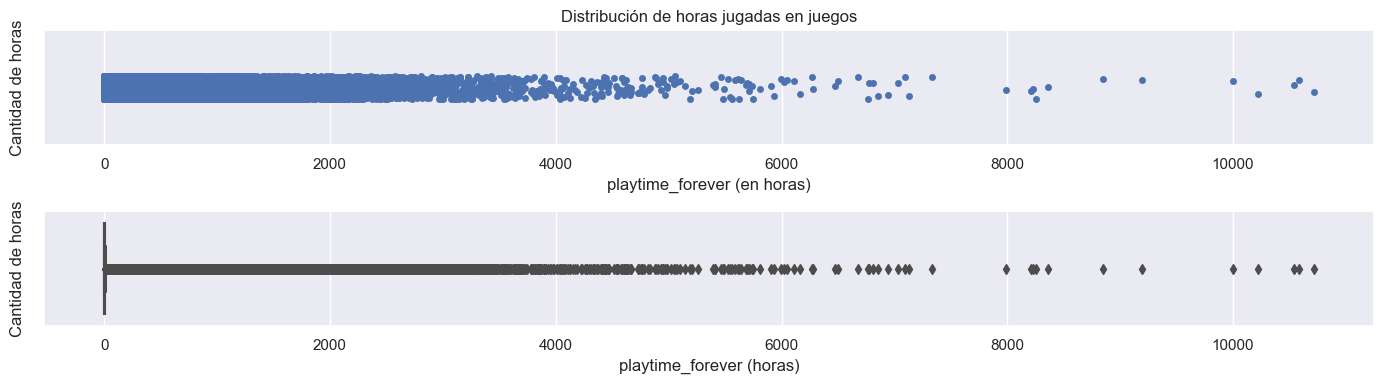

In [59]:
df_user_items['playtime_hours'] = df_user_items['playtime_forever'] / 60

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=df_user_items, x='playtime_hours', ax=ax1)
ax1.set_xlabel('playtime_forever (en horas)') ; ax1.set_ylabel('Cantidad de horas') ; ax1.set_title('Distribución de horas jugadas en juegos')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=df_user_items, x='playtime_hours', ax=ax2)
ax2.set_xlabel('playtime_forever (horas)') ; ax2.set_ylabel('Cantidad de horas')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

In [61]:
# Obtenemos algunas estadisticas
estadisticas = df_user_items['playtime_hours'].describe()
estadisticas

count    5.094105e+06
mean     1.650918e+01
std      9.023828e+01
min      0.000000e+00
25%      0.000000e+00
50%      5.666667e-01
75%      5.916667e+00
max      1.071288e+04
Name: playtime_hours, dtype: float64

In [62]:
# Cuartiles
q1 = estadisticas[4]
q3 = estadisticas[6]

# Valor del bigote
bigote_max = round(q3 + 1.5*(q3 - q1), 2)

# cantidad de atipicos (outliers)
outliers = (df_user_items['playtime_hours'] > bigote_max).sum()

print(outliers)

763606


Se puede observar que cada usuario, por juego, pasa un tiempo medio de 0.57 hs jugando y el 75% de los jugadores estuvieron menos de 6 hs jugando a un juego, pero se observa una gran cantidad de valores atípicos por encima de las 14.79 hs que juega cada usuario a un juego. Esto podría deberse al uso de bots que utilizan el mismo perfil de usuario para jugar en simultaneo, lo que generaría una distorsión de los tiempos reales de juego.

Columna 'items_count'

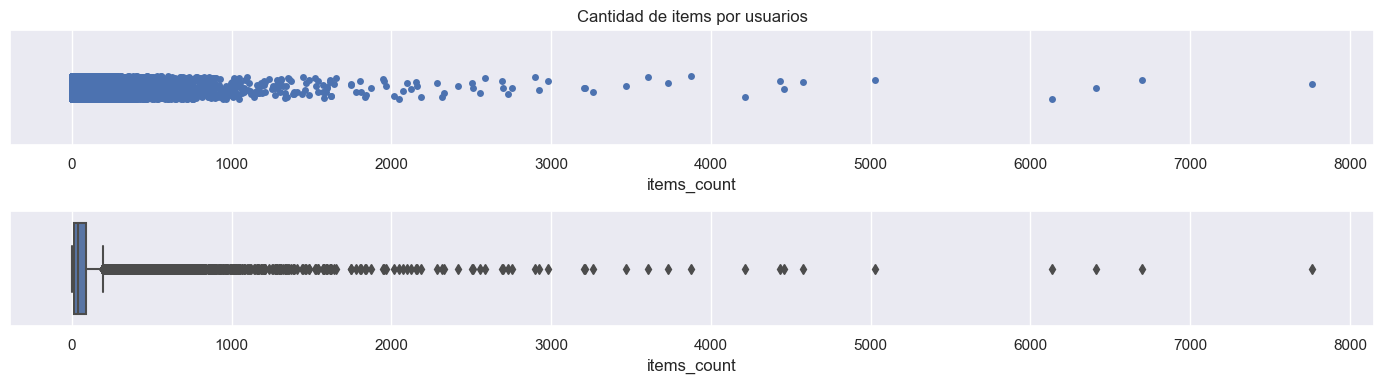

In [63]:
# Agrupa por usuario la cantidad de items, lo conviente en data frame y los ordena de mayor a menor
items_count_user = df_user_items.groupby('user_id')['items_count'].unique().explode()
items_count_user = pd.DataFrame(items_count_user)
items_count_user_o = items_count_user.sort_values('items_count', ascending=False)

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=items_count_user_o, x='items_count', ax=ax1)
ax1.set_xlabel('items_count') ; ax1.set_title('Cantidad de items por usuarios')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=items_count_user_o, x='items_count', ax=ax2)
ax2.set_xlabel('items_count')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

In [69]:
# Obtenemos algunas estadisticas
estadisticas = items_count_user['items_count'].astype(float).describe()
estadisticas

count    70912.000000
mean        71.836671
std        132.366763
min          1.000000
25%         14.000000
50%         40.000000
75%         87.000000
max       7762.000000
Name: items_count, dtype: float64

In [70]:
# Cuartiles
q1 = estadisticas[4]
q3 = estadisticas[6]

# Valor del bigote
bigote_max = round(q3 + 1.5*(q3 - q1), 2)

# cantidad de atipicos (outliers)
outliers = (items_count_user['items_count'] > bigote_max).sum()

print(outliers)

4957


Se puede ver que el usuario que mas cantidad de juegos a consumido ronda los 8000 juegos, pero el 75% de los usuarios ha adquirido menos de 87 items. Se pueden ver 4957 usuarios que hay adquirido mas de 196 items que podrían considerarse como atípicos.